<img src="logounsam.jpg" align="right" width="150">

# TS9 - Filtrado No Lineal
## Alumnas: Catalina Gonzalez Araujo y Lola Pampin
## Docentes: Mariano Llamedo Soria, Francisco Hernan Ledesma y David Ezequiel Benoit
### 2do cuatrimestre 2025

# Introducción
### Línea de base 
$$
\hat{x} = s - \hat{b}
$$
### 1. Filtro de mediana
Se estima $\hat{b}$ a partir de la siguiente expresión:

$$
\hat{b} = \operatorname{med}_{600} \Big( \operatorname{med}_{200}(s) \Big)
$$

siendo $\operatorname{med}_{t}(s)$ el operador de mediana de $t$ milisegundos que se aplica sobre la señal $s$, es decir:

$$
\hat{b} = \operatorname{med}\big(m[n], m[n-1], \dots, m[n - 600 \cdot f_s]\big)
$$

donde

$$
m[n] = \operatorname{med}\big(s[n], s[n-1], \dots, s[n - 200 \cdot f_s]\big)
$$
### 2. Interpolación mediante splines cúbicos
### 3. Filtro adaptado (matched filter)

"En procesamiento de señales, la salida del filtro adaptado se obtiene correlacionando una señal conocida y retardada, denominada plantilla, con una señal desconocida, con el objetivo de detectar la presencia de dicha plantilla en la señal analizada. Este procedimiento es equivalente a convolucionar la señal desconocida con una versión conjugada e invertida en el tiempo de la plantilla. El filtro adaptado constituye el filtro lineal óptimo para maximizar la relación señal-ruido (SNR) en presencia de ruido estocástico aditivo."

Dentro de sus ventajas se puede mencionar:
- Máxima relación señal-ruido (SNR): Es el filtro lineal óptimo para detectar señales en presencia de ruido aditivo estocástico.
- Alta sensibilidad: Permite detectar señales débiles que se encuentran sumergidas en ruido.
- Aplicabilidad en múltiples dominios: Se utiliza en radar, comunicaciones, procesamiento de imágenes, sismología y astronomía.
- Robustez frente a ruido blanco: Su diseño está optimizado para entornos donde el ruido es gaussiano y aditivo.
- Facilidad de implementación digital: Puede implementarse mediante correlación o convolución, lo que lo hace compatible con sistemas digitales.


Respecto a las desventajas:

- Dependencia de la señal conocida: Requiere conocer la forma exacta de la señal o plantilla para diseñar el filtro.
- Sensibilidad a errores de sincronización: Un desfase temporal entre la señal recibida y la plantilla reduce significativamente el rendimiento.
- Alto costo computacional: La correlación o convolución con señales largas puede ser costosa en tiempo y recursos.
- No óptimo ante ruido no gaussiano: Su desempeño se degrada si el ruido no cumple las condiciones asumidas (ruido blanco gaussiano).
- Vulnerabilidad a interferencias: Si existen señales similares a la plantilla, puede producir falsas detecciones.

# Desarrollo


In [14]:
# INCLUDES

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io as sio
import matplotlib.patches as patches
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks

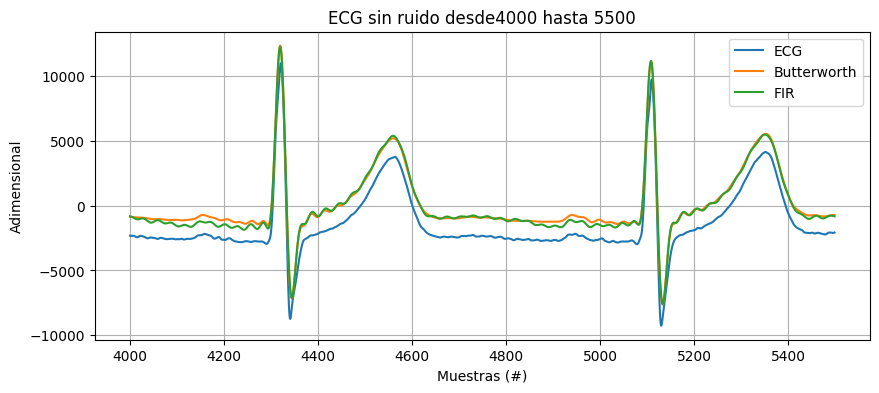

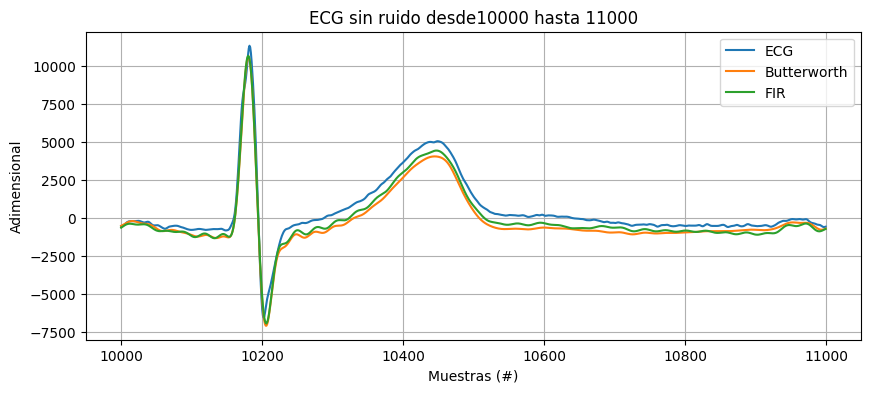

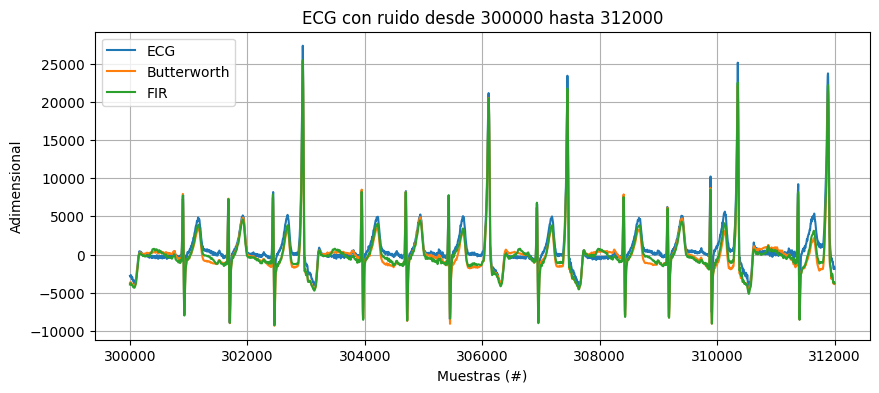

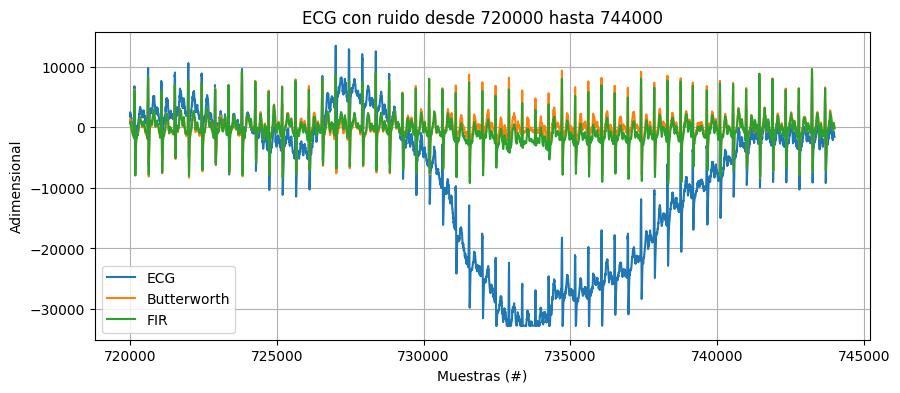

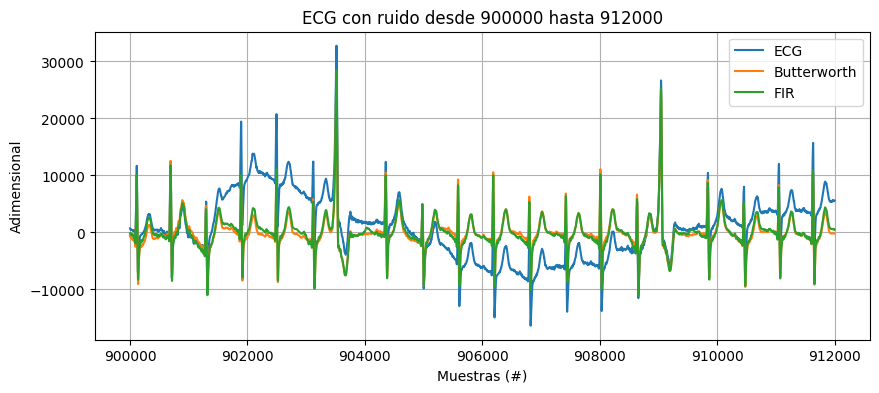

In [15]:
# TS8

# %% 1) PLANTILLA DE DISEÑO - PASABANDA DIGITAL

fs = 1000  # [Hz]
wp = (0.8, 35)
ws = (0.1, 40)

# Atenuaciones (divididas entre 2 porque se filtra forward + backward)
alpha_p = 0.5     # dB
alpha_s = 20      # dB


# %% 2) DISEÑO IIR (BUTTER - CHEBY1 - CHEBY2 - CAUER)

mi_sos_butt  = signal.iirdesign(wp, ws, gpass=alpha_p, gstop=alpha_s, ftype='butter', fs=fs, output='sos')

mi_sos_cauer = signal.iirdesign(wp, ws, gpass=alpha_p, gstop=alpha_s, ftype='ellip', fs=fs, output='sos')

mi_sos_cheb1 = signal.iirdesign(wp, ws, gpass=alpha_p, gstop=alpha_s, ftype='cheby1', fs=fs, output='sos')

# mi_sos_cheb2 = sig.iirdesign(wp, ws, gpass=alpha_p, gstop=alpha_s, ftype='cheby2', fs=fs, output='sos')

# Elegimos dos para graficar
mi_sos1 = mi_sos_cauer
tipo1 = "Cauer"

mi_sos2 = mi_sos_cheb1
tipo2 = "Cheby 1"

# Respuesta en frecuenia (uso sosfreqz)
w1, h1 = signal.sosfreqz(mi_sos1, worN=2048, fs=fs)
w2, h2 = signal.sosfreqz(mi_sos2, worN=2048, fs=fs)

# Fase
fase1 = np.unwrap(np.angle(h1))
w_rad1 = w1 / (fs/2) * np.pi
gd1 = -np.diff(fase1) / np.diff(w_rad1)

fase2 = np.unwrap(np.angle(h2))
w_rad2 = w2 / (fs/2) * np.pi
gd2 = -np.diff(fase2) / np.diff(w_rad2)

# %% 2) DISEÑO FIR (FIRWIN2 y FIRLS)

frecuencias = np.array([0, 0.1, 0.8, 35, 35.7, fs/2])
deseado     = np.array([0, 0, 1, 1, 0, 0])

# FIR con ventana rectangular
numtaps = 1001
fir_win = signal.firwin2(numtaps, frecuencias, deseado, fs=fs, window='boxcar')
retardo = (numtaps - 1)//2

# FIR Least-Squares
numtaps_ls = 2001  # impar
fir_ls = signal.firls(numtaps_ls, frecuencias, deseado, fs=fs)
retardo_ls = (numtaps_ls - 1)//2

# Respuesta en frecuencia
w_fir, h_fir = signal.freqz(fir_win, worN=2048, fs=fs)
fase_fir = np.unwrap(np.angle(h_fir))
gd_fir = -np.diff(fase_fir) / np.diff(w_fir/fs*np.pi)

w_ls, h_ls = signal.freqz(fir_ls, worN=2048, fs=fs)
fase_ls = np.unwrap(np.angle(h_ls))
gd_ls = -np.diff(fase_ls) / np.diff(w_ls/fs*np.pi)

# %% CARGO EL ECG REAL

mat = sio.loadmat('./ecg.mat')
ecg_raw = mat['ecg_lead'].flatten()
N = len(ecg_raw)

# ---- Filtrado ----
ecg_filt_iir = signal.sosfiltfilt(mi_sos_butt, ecg_raw)
ecg_filt_fir = signal.filtfilt(fir_win, 1, ecg_raw)

# %% GRAFICOS — ZONAS SIN RUIDO

regiones_sin_ruido = [
    [4000, 5500],
    [10000, 11000]
]

for r in regiones_sin_ruido:
    a,b = r
    t = np.arange(a,b)

    plt.figure(figsize=(10,4))
    plt.plot(t, ecg_raw[t], label="ECG")
    plt.plot(t, ecg_filt_iir[t], label="Butterworth")
    plt.plot(t, ecg_filt_fir[t], label="FIR")
    plt.title('ECG sin ruido desde' + str(r[0]) + ' hasta ' + str(r[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    plt.legend()
    plt.grid()

# %% GRAFICOS — ZONAS CON RUIDO

regiones_ruidosas = [
    (np.array([5, 5.2])*60*fs).astype(int),
    (np.array([12, 12.4])*60*fs).astype(int),
    (np.array([15, 15.2])*60*fs).astype(int)
]

for r in regiones_ruidosas:
    a,b = r
    t = np.arange(a,b)

    plt.figure(figsize=(10,4))
    plt.plot(t, ecg_raw[t], label="ECG")
    plt.plot(t, ecg_filt_iir[t], label="Butterworth")
    plt.plot(t, ecg_filt_fir[t], label="FIR")
    plt.title('ECG con ruido desde ' + str(r[0]) + ' hasta ' + str(r[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    plt.legend()
    plt.grid()

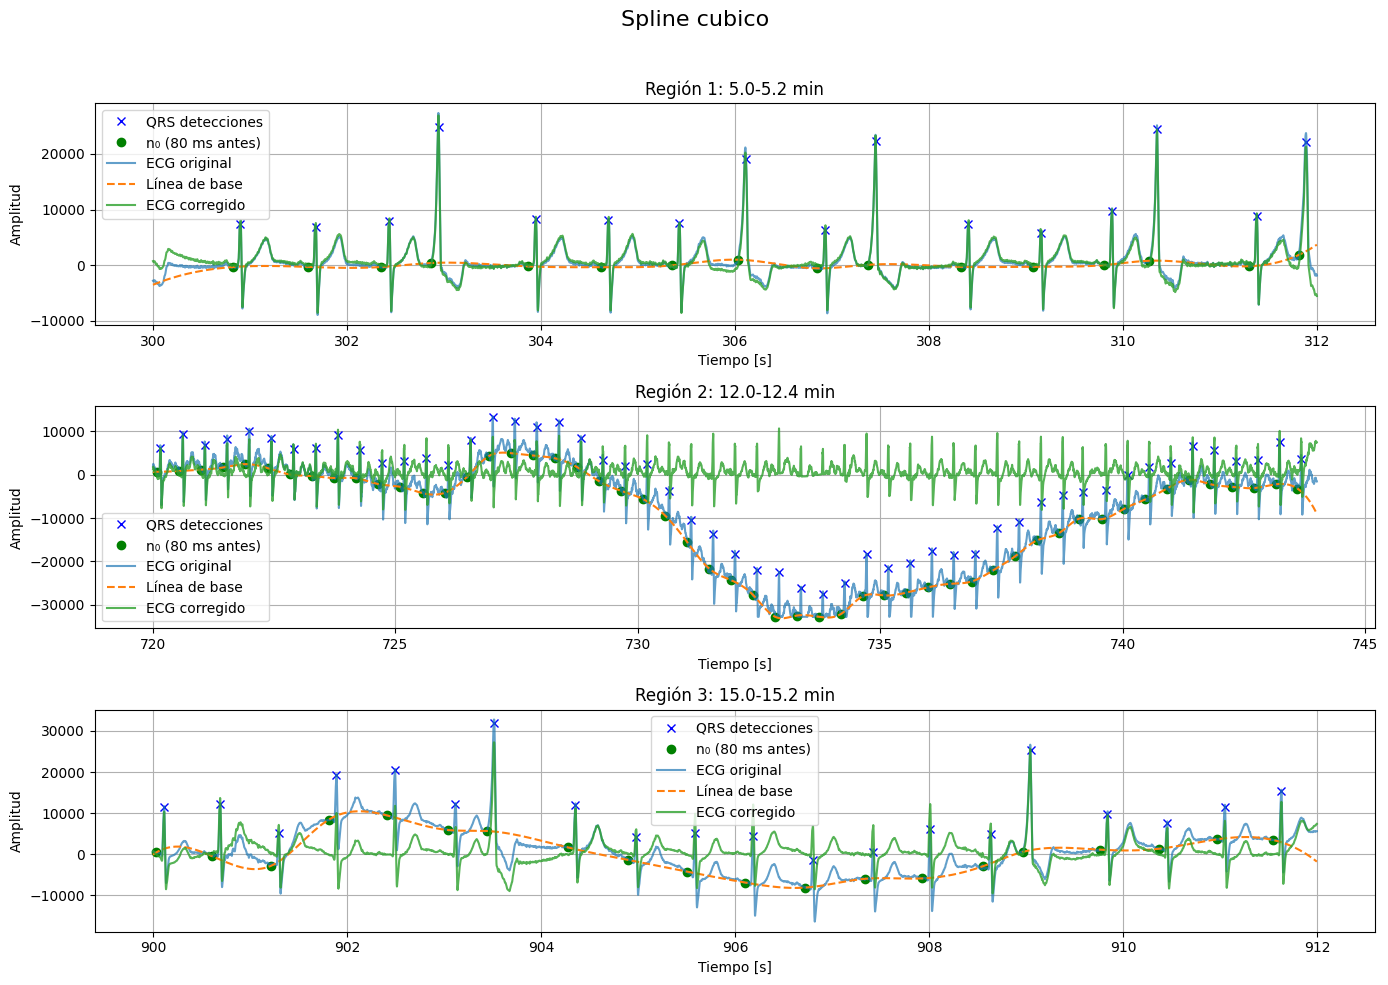

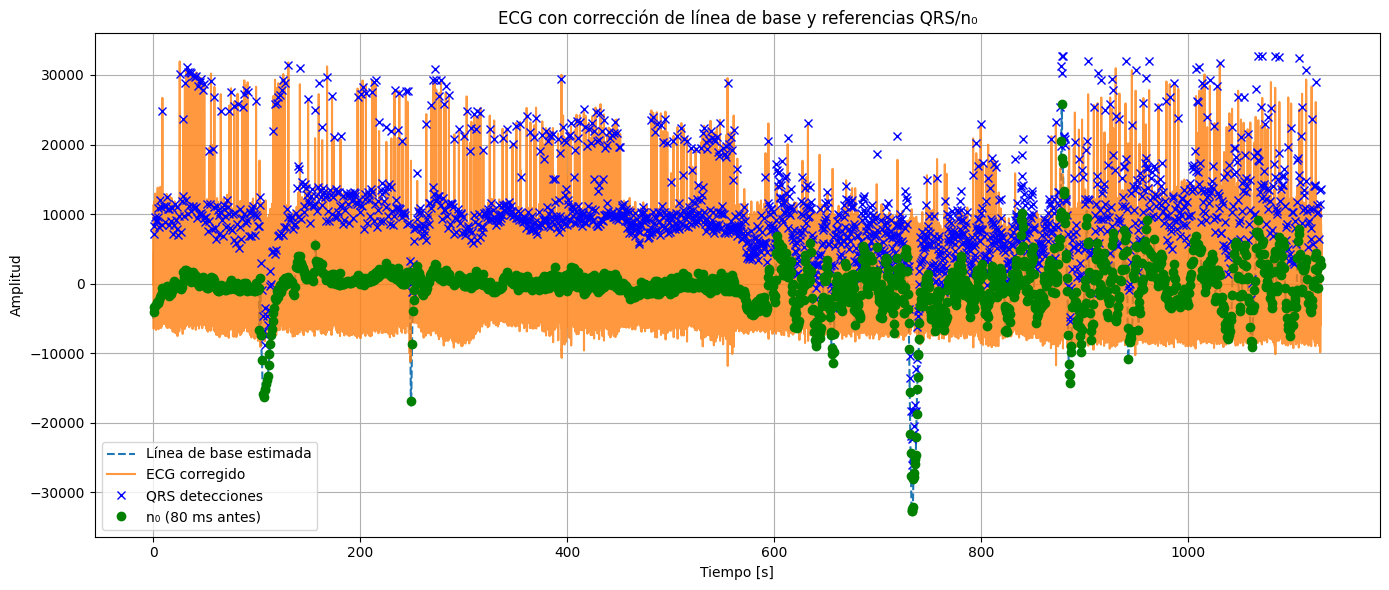

In [16]:
# %% TS9

# Interpolacion --> metodo estimacion sustraccion
qrs_detections = mat['qrs_detections'].flatten()
n0 = int(0.08 * fs)  # 80 ms antes del QRS


# Construir puntos S
m_points = qrs_detections - n0
m_points = m_points[m_points > 0]  # evitar índices negativos
s_values = ecg_raw[m_points] 

# Interpolación spline cúbica
cs = CubicSpline(m_points, s_values)
baseline = cs(np.arange(len(ecg_raw)))

# ECG corregido (remover línea de base)
ecg_corrected = ecg_raw - baseline

# Crear una sola figura con subplots
fig, axes = plt.subplots(len(regiones_ruidosas), 1, figsize=(14, 10), sharex=False)


# Título general para toda la figura
fig.suptitle("Spline cubico", fontsize=16)

for idx, reg in enumerate(regiones_ruidosas):
    start, end = reg.astype(int)
    ecg_region = ecg_raw[start:end]
    t_region = np.arange(start, end) / fs

    # Filtrar QRS en la región
    qrs_region = qrs_detections[(qrs_detections >= start) & (qrs_detections < end)]

    # Construir puntos PQ
    m_points = qrs_region - n0
    m_points = m_points[m_points > start]
    s_values = ecg_raw[m_points]

    # Interpolación spline cúbica
    cs = CubicSpline(m_points, s_values)
    baseline_region = cs(np.arange(start, end))

    # ECG corregido
    ecg_corrected = ecg_region - baseline_region
    
    
    # Agregar cruces verdes en QRS detectados
    axes[idx].plot(t_region[qrs_region - start], ecg_region[qrs_region - start], 'bx', label='QRS detecciones')
    
    axes[idx].plot(t_region[m_points - start], ecg_region[m_points - start], 'go', label='n₀ (80 ms antes)')


    # Graficar en el subplot correspondiente
    axes[idx].plot(t_region, ecg_region, label='ECG original', alpha=0.7)
    axes[idx].plot(t_region, baseline_region, label='Línea de base', linestyle='--')
    axes[idx].plot(t_region, ecg_corrected, label='ECG corregido', alpha=0.8)
    axes[idx].set_title(f'Región {idx+1}: {start/fs/60:.1f}-{end/fs/60:.1f} min')
    axes[idx].set_xlabel('Tiempo [s]')
    axes[idx].set_ylabel('Amplitud')
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar para que no tape el título general
plt.show()


# %% Para todo el ecg
qrs_detections = mat['qrs_detections'].flatten()
n0 = int(0.08 * fs)  # 80 ms antes del QRS


# Construir puntos S
m_points = qrs_detections - n0
m_points = m_points[m_points > 0]  # evitar índices negativos
s_values = ecg_raw[m_points] 

# Interpolación spline cúbica
cs = CubicSpline(m_points, s_values)
baseline = cs(np.arange(len(ecg_raw)))

# ECG corregido (remover línea de base)
ecg_corrected = ecg_raw - baseline

# Vector de tiempo
t = np.arange(len(ecg_raw)) / fs

# Graficar
plt.figure(figsize=(14, 6))
#plt.plot(t, ecg_raw, label='ECG original (con ruido)', alpha=0.7)
plt.plot(t, baseline, label='Línea de base estimada', linestyle='--')
plt.plot(t, ecg_corrected, label='ECG corregido', alpha=0.8)

# QRS detections (cruces azules)
plt.plot(t[qrs_detections], ecg_raw[qrs_detections], 'bx', label='QRS detecciones')

# m_points (círculos verdes)
m_points = qrs_detections - n0
m_points = m_points[m_points > 0]  # evitar negativos
plt.plot(t[m_points], ecg_raw[m_points], 'go', label='n₀ (80 ms antes)')

# Configuración
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('ECG con corrección de línea de base y referencias QRS/n₀')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
# ============================
# 1. Crear filtro adaptado
# ============================

patron= mat_struct['qrs_pattern1'].flatten()
patron_2 = patron - np.mean(patron) #para tener area neta nula, util para filtrar
# ============================
# 2. Correlación (convolución)
# ============================
ecg_detection = signal.lfilter(b=patron_2, a=1, x=ecg_one_lead)
ecg_detection_abs = np.abs(ecg_detection)
ecg_detection_abs = ecg_detection_abs/np.std(ecg_detection_abs)
# ============================
# 3. Detectar picos con find_peaks
# ============================
threshold = 0.5 * np.max(ecg_detection_abs)  # umbral simple
peaks, properties = find_peaks(ecg_detection_abs, height=threshold, distance=100)

# ============================
# 4. Comparar con ground truth
# ============================
TP = sum([any(abs(p - qrs_detections) <= 20) for p in peaks])
FP = len(peaks) - TP
FN = len(qrs_detections) - TP
sensibilidad = TP / (TP + FN)
# ppv = TP / (TP + FP)

print("Resultados del detector:")
print(f"Número de picos detectados: {len(peaks)}")
# print(f"TP: {TP}, FP: {FP}, FN: {FN}")
# print(f"Sensibilidad: {sensibilidad:.2f}, PPV: {ppv:.2f}")

# ============================
# 5. Graficar resultados
# ============================
plt.figure(figsize=(12, 6))

# Señal ECG con detecciones
plt.subplot(2, 1, 1)
plt.plot(ecg_one_lead, label='ECG')
plt.scatter(qrs_detections, ecg_one_lead[qrs_detections], color='green', label='Ground Truth')
plt.scatter(peaks, ecg_one_lead[peaks], color='red', label='Detectados')
plt.title('Señal ECG con detecciones')
plt.legend()

# Salida del filtro adaptado
plt.subplot(2, 1, 2)
plt.plot(ecg_detection, label='Correlación (Filtro adaptado)')
plt.scatter(peaks, ecg_detection[peaks], color='red', label='Picos detectados')
plt.title('Salida del filtro adaptado')
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'mat_struct' is not defined

# Conclusiones